In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm

In [12]:
def plt2D(fig, ax, x, y, z, z1 = [0], cmap=cm.viridis, levels=np.linspace(0, 40, 10 + 1), 
          levels1 = [35., 40., 45.], title = '', ylabel = '', zlabel = 'Cloud Fraction (%)',
          xlabel = False, cbar = True, extend = 'both', fontsize = 12, 
          yrange = [0., 3.], xrange = [-6, 6], plotregion = False):
    
    oax = ax.contourf(x, y, z, cmap=cmap, levels=levels, extend=extend)
    
    if np.size(z1) > 1:
        CS = ax.contour(x, y, z1, levels=levels1, colors='black', linewidths=0.4)
        plt.clabel(CS, fontsize=7, inline=1, fmt='%2.0f')
        
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    ax.set_ylabel(ylabel, fontsize=fontsize) 
    if xlabel:
        ax.set_xlabel('Distance from ice edge \n ($\degree$ latitude)', fontsize=fontsize) 
    
    ax.set_title(title, fontsize=fontsize)
    
    ax.axvline(x=0., color='black', lw=0.5, linestyle='--')
    
    if plotregion:
        ax.axvline(x=-2., color='grey', lw=0.5, linestyle='--')
        ax.axvline(x=2., color='grey', lw=0.5, linestyle='--')
            
    if cbar:
        cbar = fig.colorbar(oax, ax=ax, orientation='vertical', shrink=0.8, aspect=15, 
                            ticks=[levels.min(), levels.max()])
        cbar.set_label(zlabel, fontsize=0.8*fontsize)
    
    return oax

In [13]:
file_2d = "/home/rcostell/Observation_Files/Binned/New_Observed_2D_CF.nc"
file_3d_cl = "/home/rcostell/Observation_Files/Binned/New_Observed_3D.nc"
file_3d_ta = "/home/rcostell/Observation_Files/Binned/New_Observed_3D_Ta.nc"

# === Open datasets and seasonal mean ===
f2_obs = xr.open_dataset(file_2d).groupby("time.season").mean()
f3_cl = xr.open_dataset(file_3d_cl).groupby("time.season").mean()
f3_ta = xr.open_dataset(file_3d_ta).groupby("time.season").mean()

# Convert pressure levels from Pa → hPa (if needed)
#if "level" in f3_ta:
   # f3_ta["level"] = f3_ta["level"] / 100  

# === LTS calculation from temperature ===
pres = f3_ta.level.expand_dims(distance=f3_ta["distance"].size).transpose().expand_dims(season=f3_ta["season"].size)
T_kelvin = f3_ta.air + 273.15  # convert to Kelvin
theta = T_kelvin * (1000.0 / pres) ** 0.286
lts = theta.isel(level=3) - theta.isel(level=0)
f3_ta["lts"] = lts

# === Seasonal splits ===
djf_data_2d = f2_obs.sel(season="DJF")
jja_data_2d = f2_obs.sel(season="JJA")
djf_data_3d_cl = f3_cl.sel(season="DJF")
jja_data_3d_cl = f3_cl.sel(season="JJA")
djf_data_3d_ta = f3_ta.sel(season="DJF")
jja_data_3d_ta = f3_ta.sel(season="JJA")

# === Coordinates ===
# Only keep -6 to 6 degrees around ice edge
def restrict_distance(ds, lim=7):
    return ds.sel(distance=slice(-lim, lim))

djf_data_2d = restrict_distance(djf_data_2d)
jja_data_2d = restrict_distance(jja_data_2d)
djf_data_3d_cl = restrict_distance(djf_data_3d_cl)
jja_data_3d_cl = restrict_distance(jja_data_3d_cl)
djf_data_3d_ta = restrict_distance(djf_data_3d_ta)
jja_data_3d_ta = restrict_distance(jja_data_3d_ta)

x2d = djf_data_2d.distance.values
x3d_cl = djf_data_3d_cl.distance.values
x3d_ta = djf_data_3d_ta.distance.values
y_alt = djf_data_3d_cl.altitude.values

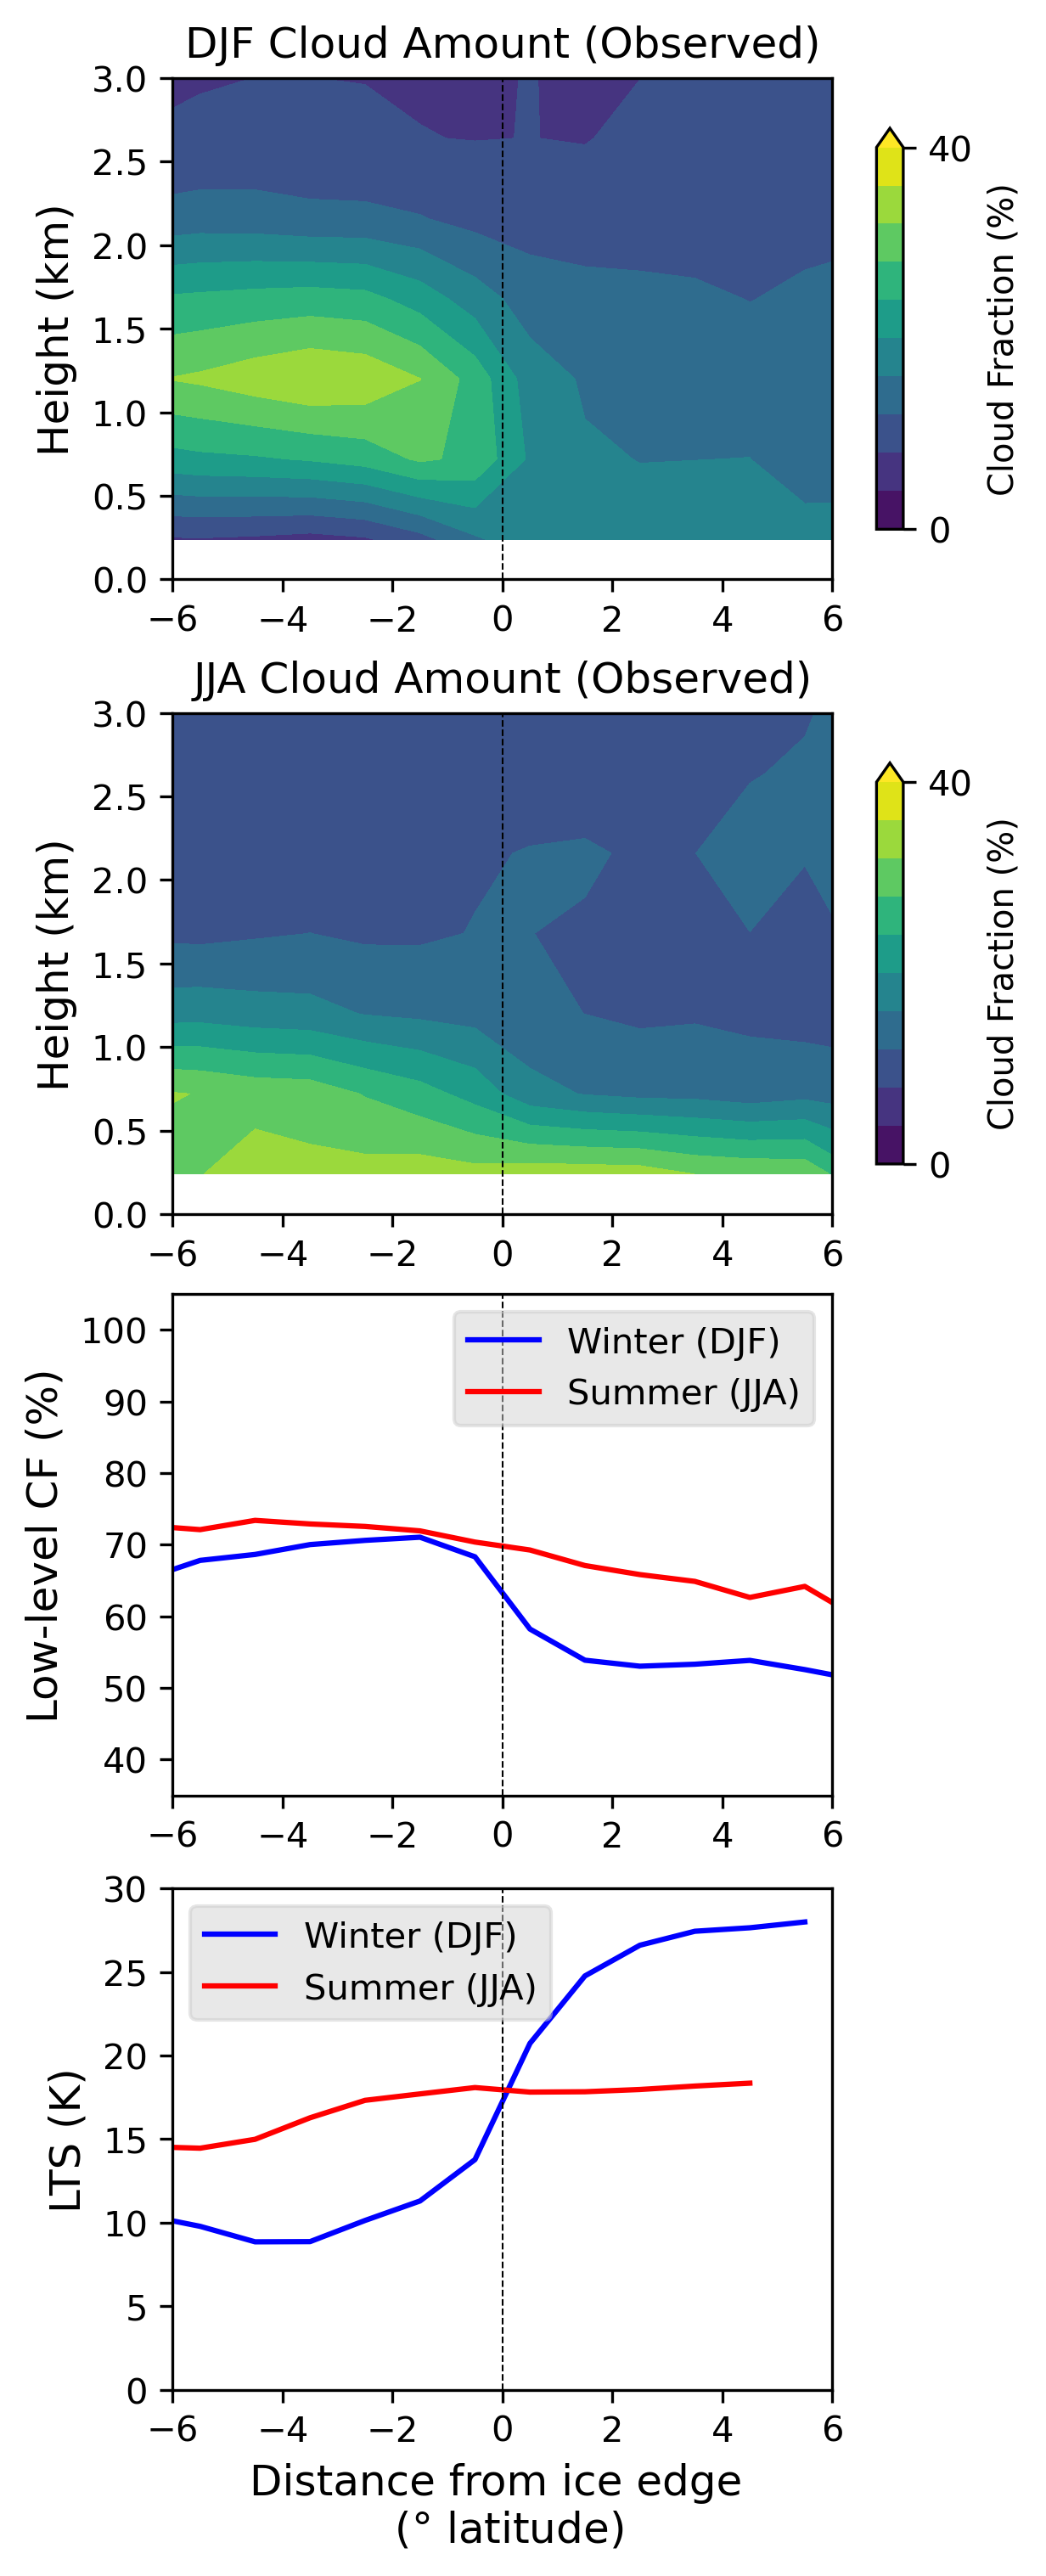

In [15]:
# === Figure setup ===
myfontsize = 12
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 10), dpi=300, constrained_layout=True)

# --- Row 1: DJF Cloud Fraction (3D, altitude) ---
plt2D(fig, axs[0], x3d_cl, y_alt, djf_data_3d_cl.clcalipso.values*100, extend='max',
      title="DJF Cloud Amount (Observed)", ylabel="Height (km)",
      fontsize=myfontsize, cbar=True, yrange=[0., 3.])

# --- Row 2: JJA Cloud Fraction (3D, altitude) ---
plt2D(fig, axs[1], x3d_cl, y_alt, jja_data_3d_cl.clcalipso.values*100,
      title="JJA Cloud Amount (Observed)", ylabel="Height (km)", extend='max',
      fontsize=myfontsize, cbar=True, yrange=[0., 3.])

# --- Row 3: Low-level CF DJF & JJA (2D line plot) ---
axs[2].plot(x2d, djf_data_2d.cllcalipso.values*100, color="blue", lw=1.5, label="Winter (DJF)")
axs[2].plot(x2d, jja_data_2d.cllcalipso.values*100, color="red", lw=1.5, label="Summer (JJA)")
axs[2].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[2].set_ylim([35., 105.])
axs[2].set_xlim([-6, 6])
axs[2].set_ylabel("Low-level CF (%)", fontsize=myfontsize)
legend = axs[2].legend(loc="upper right", fontsize=myfontsize-2, frameon=True)
legend.get_frame().set_facecolor("lightgray")
legend.get_frame().set_alpha(0.5)

# --- Row 4: LTS DJF & JJA (2D line plot) ---
axs[3].plot(x3d_ta, djf_data_3d_ta.lts, color="blue", lw=1.5, label="Winter (DJF)")
axs[3].plot(x3d_ta, jja_data_3d_ta.lts, color="red", lw=1.5, label="Summer (JJA)")
axs[3].axvline(x=0., color="black", lw=0.5, linestyle="--")
axs[3].set_ylim([0., 30.])
axs[3].set_xlim([-6, 6])
axs[3].set_xlabel("Distance from ice edge \n ($\degree$ latitude)", fontsize=myfontsize)
axs[3].set_ylabel("LTS (K)", fontsize=myfontsize)
legend = axs[3].legend(loc="upper left", fontsize=myfontsize-2, frameon=True)
legend.get_frame().set_facecolor("lightgray")
legend.get_frame().set_alpha(0.5)

#plt.savefig("/home/rcostell/Projects/CMIP6_Intercomparison/Observations/Output_Figures/Observed_Figure_2.png", dpi=600)
plt.show()